In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

In [0]:
# Running in Google Colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/data


**Not doing EDA and other pre-processing. Directly working on the assignment. And lot of code is taken from original notebook.**

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

<h2>Modeling with less data points (0.5M data points) and more weight to title and 500 tags only</h2>

In [0]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


**Converting string Tags to multilable output variables**

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

**Selecting 500 Tags**

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

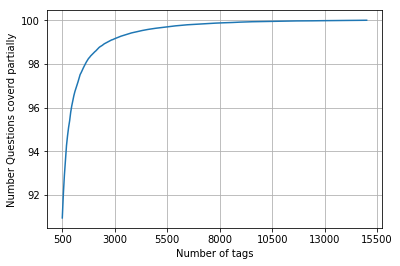

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [0]:
train_datasize = 400000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h1>Assignments</h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

<h3>Featurizing data with Count vectorizer</h3>

In [0]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, \
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:06:45.229803


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


<h3>Applying Logistic Regression with OneVsRest Classifier</h3>

In [0]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [0]:
predictions = classifier.predict(x_test_multilabel)

print("For alpha = 0.00001")
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For alpha = 0.00001
Accuracy : 0.09716
Hamming loss  0.00580116
Micro-average quality numbers
Precision: 0.2911, Recall: 0.4660, F1-measure: 0.3583
Macro-average quality numbers
Precision: 0.2061, Recall: 0.4068, F1-measure: 0.2653


In [0]:
start = datetime.now()
log_classifiers = {0.00001: classifier}
alphas = [0.001, 0.1, 1]
for alpha in alphas: 
  classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha, penalty='l1'))
  classifier.fit(x_train_multilabel, y_train)
  predictions = classifier.predict(x_test_multilabel)

  print("For alpha = {}".format(alpha))
  print("Accuracy :",metrics.accuracy_score(y_test, predictions))
  print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

  precision = precision_score(y_test, predictions, average='micro')
  recall = recall_score(y_test, predictions, average='micro')
  f1 = f1_score(y_test, predictions, average='micro')
  
  print("Micro-average quality numbers")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

  precision = precision_score(y_test, predictions, average='macro')
  recall = recall_score(y_test, predictions, average='macro')
  f1 = f1_score(y_test, predictions, average='macro')

  print("Macro-average quality numbers")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
  log_classifiers[alpha] = classifier
  

#   print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

For alpha = 0.001
Accuracy : 0.1937
Hamming loss  0.0031152
Micro-average quality numbers
Precision: 0.6039, Recall: 0.3019, F1-measure: 0.4025
Macro-average quality numbers
Precision: 0.4175, Recall: 0.2321, F1-measure: 0.2794
For alpha = 0.1
Accuracy : 0.12911
Hamming loss  0.00343118
Micro-average quality numbers
Precision: 0.9291, Recall: 0.0140, F1-measure: 0.0276
Macro-average quality numbers
Precision: 0.0019, Recall: 0.0009, F1-measure: 0.0012
For alpha = 1
Accuracy : 0.12065
Hamming loss  0.00347624
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Macro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Time taken to run this cell : 2:01:02.817008


In [0]:
log_classifiers

{1e-05: OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                             class_weight=None,
                                             early_stopping=False, epsilon=0.1,
                                             eta0=0.0, fit_intercept=True,
                                             l1_ratio=0.15,
                                             learning_rate='optimal', loss='log',
                                             max_iter=1000, n_iter_no_change=5,
                                             n_jobs=None, penalty='l1',
                                             power_t=0.5, random_state=None,
                                             shuffle=True, tol=0.001,
                                             validation_fraction=0.1, verbose=0,
                                             warm_start=False),
                     n_jobs=None),
 0.001: OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,


<h3>Applying Linear SVM with OneVsRest Classifier</h3>

In [18]:
start = datetime.now()
hinge_classifiers = {}
alphas = [0.00001, 0.001, 0.1, 1]
for alpha in alphas: 
  classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=alpha, penalty='l1'))
  classifier.fit(x_train_multilabel, y_train)
  predictions = classifier.predict(x_test_multilabel)

  print("For alpha = {}".format(alpha))
  print("Accuracy :",metrics.accuracy_score(y_test, predictions))
  print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

  precision = precision_score(y_test, predictions, average='micro')
  recall = recall_score(y_test, predictions, average='micro')
  f1 = f1_score(y_test, predictions, average='micro')
  
  print("Micro-average quality numbers")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

  precision = precision_score(y_test, predictions, average='macro')
  recall = recall_score(y_test, predictions, average='macro')
  f1 = f1_score(y_test, predictions, average='macro')

  print("Macro-average quality numbers")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
  hinge_classifiers[alpha] = classifier
  

#   print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

For alpha = 1e-05
Accuracy : 0.099
Hamming loss  0.00574442
Micro-average quality numbers
Precision: 0.2945, Recall: 0.4677, F1-measure: 0.3614
Macro-average quality numbers
Precision: 0.2089, Recall: 0.4089, F1-measure: 0.2682
For alpha = 0.001
Accuracy : 0.19105
Hamming loss  0.00314352
Micro-average quality numbers
Precision: 0.5967, Recall: 0.2954, F1-measure: 0.3952
Macro-average quality numbers
Precision: 0.3265, Recall: 0.2276, F1-measure: 0.2519
For alpha = 0.1
Accuracy : 0.12975
Hamming loss  0.00342498
Micro-average quality numbers
Precision: 0.8213, Recall: 0.0188, F1-measure: 0.0369
Macro-average quality numbers
Precision: 0.0043, Recall: 0.0013, F1-measure: 0.0020
For alpha = 1
Accuracy : 0.12065
Hamming loss  0.00347624
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Macro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Time taken to run this cell : 5:53:04.814878


### As we see the perforamce at alpha = 1e-5 and 1e-3 is good for both models. We can train model at 1e-4 and see the performance

In [19]:
alpha = 0.0001
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("For alpha = {}".format(alpha))
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
# log_classifiers[alpha] = classifier

For alpha = 0.0001
Accuracy : 0.15549
Hamming loss  0.00370748
Micro-average quality numbers
Precision: 0.4633, Recall: 0.4201, F1-measure: 0.4407
Macro-average quality numbers
Precision: 0.3563, Recall: 0.3642, F1-measure: 0.3474


In [20]:
alpha = 0.0001
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=alpha, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("For alpha = {}".format(alpha))
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
hinge_classifiers[alpha] = classifier

For alpha = 0.0001
Accuracy : 0.15196
Hamming loss  0.00372004
Micro-average quality numbers
Precision: 0.4613, Recall: 0.4177, F1-measure: 0.4384
Macro-average quality numbers
Precision: 0.3403, Recall: 0.3587, F1-measure: 0.3377


In [21]:
hinge_classifiers

{1e-05: OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                             class_weight=None,
                                             early_stopping=False, epsilon=0.1,
                                             eta0=0.0, fit_intercept=True,
                                             l1_ratio=0.15,
                                             learning_rate='optimal',
                                             loss='hinge', max_iter=1000,
                                             n_iter_no_change=5, n_jobs=None,
                                             penalty='l1', power_t=0.5,
                                             random_state=None, shuffle=True,
                                             tol=0.001, validation_fraction=0.1,
                                             verbose=0, warm_start=False),
                     n_jobs=None),
 0.0001: OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=Fal

**We can see the performance at alpha = 1e-4 is better than other values. Printing all performance values here as they are not well printed in the above output cells. and also table is created at end.**

**For Linear Regression (SGDClassifier with log loss):**
- <b>For alpha = 0.00001 <br/>
Accuracy : 0.09716 <br/>
Hamming loss  0.00580116 <br/>
Micro-average quality numbers <br/>
Precision: 0.2911, Recall: 0.4660, F1-measure: 0.3583 <br/>
Macro-average quality numbers <br/>
Precision: 0.2061, Recall: 0.4068, F1-measure: 0.2653</b>
- <b>For alpha = 0.0001 <br/>
Accuracy : 0.15549 <br/>
Hamming loss  0.00370748 <br/>
Micro-average quality numbers <br/>
Precision: 0.4633, Recall: 0.4201, F1-measure: 0.4407 <br/>
Macro-average quality numbers <br/>
Precision: 0.3563, Recall: 0.3642, F1-measure: 0.3474 </b>
- <b>For alpha = 0.001 <br/>
Accuracy : 0.1937 <br/>
Hamming loss  0.0031152 <br/>
Micro-average quality numbers <br/>
Precision: 0.6039, Recall: 0.3019, F1-measure: 0.4025 <br/>
Macro-average quality numbers <br/>
Precision: 0.4175, Recall: 0.2321, F1-measure: 0.2794 </b>
- <b>For alpha = 0.1 <br/>
Accuracy : 0.12911 <br/>
Hamming loss  0.00343118 <br/>
Micro-average quality numbers <br/>
Precision: 0.9291, Recall: 0.0140, F1-measure: 0.0276 <br/>
Macro-average quality numbers <br/>
Precision: 0.0019, Recall: 0.0009, F1-measure: 0.0012</b>
- <b>For alpha = 1 <br/>
Accuracy : 0.12065 <br/>
Hamming loss  0.00347624 <br/>
Micro-average quality numbers <br/>
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000 <br/>
Macro-average quality numbers <br/>
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Time taken to run this cell : 2:01:02.817008</b>

**For Linear-SVM (SGDClassifier with hinge loss):**
- <b>For alpha = 1e-05 <br/>
Accuracy : 0.099 <br/>
Hamming loss  0.00574442 <br/>
Micro-average quality numbers <br/>
Precision: 0.2945, Recall: 0.4677, F1-measure: 0.3614 <br/>
Macro-average quality numbers <br/>
Precision: 0.2089, Recall: 0.4089, F1-measure: 0.2682</b>
- <b>For alpha = 0.0001 <br/>
Accuracy : 0.15196 <br/>
Hamming loss  0.00372004 <br/>
Micro-average quality numbers <br/>
Precision: 0.4613, Recall: 0.4177, F1-measure: 0.4384 <br/>
Macro-average quality numbers <br/>
Precision: 0.3403, Recall: 0.3587, F1-measure: 0.3377</b>
- <b>For alpha = 0.001 <br/>
Accuracy : 0.19105 <br/>
Hamming loss  0.00314352 <br/>
Micro-average quality numbers <br/>
Precision: 0.5967, Recall: 0.2954, F1-measure: 0.3952 <br/>
Macro-average quality numbers <br/>
Precision: 0.3265, Recall: 0.2276, F1-measure: 0.2519</b>
- <b>For alpha = 0.1 <br/>
Accuracy : 0.12975 <br/>
Hamming loss  0.00342498 <br/>
Micro-average quality numbers <br/>
Precision: 0.8213, Recall: 0.0188, F1-measure: 0.0369 <br/>
Macro-average quality numbers <br/>
Precision: 0.0043, Recall: 0.0013, F1-measure: 0.0020</b>
- <b>For alpha = 1 <br/>
Accuracy : 0.12065 <br/>
Hamming loss  0.00347624 <br/>
Micro-average quality numbers <br/>
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000 <br/>
Macro-average quality numbers <br/>
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000</b>

## Conclusion:

In [2]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'alpha (hyper-parameter)', 'micro-f1', 'Accuracy']
table.add_row(['Logistic Regression', 0.0001, 0.4407, 0.1555])
table.add_row(['Logistic Regression', 0.001, 0.4025, 0.1937])
table.add_row(['Linear SVM', 0.0001, 0.4384, 0.152])
table.add_row(['Linear SVM', 0.001, 0.3952, 0.191])

print(table)

+---------------------+-------------------------+----------+----------+
|        Model        | alpha (hyper-parameter) | micro-f1 | Accuracy |
+---------------------+-------------------------+----------+----------+
| Logistic Regression |          0.0001         |  0.4407  |  0.1555  |
| Logistic Regression |          0.001          |  0.4025  |  0.1937  |
|      Linear SVM     |          0.0001         |  0.4384  |  0.152   |
|      Linear SVM     |          0.001          |  0.3952  |  0.191   |
+---------------------+-------------------------+----------+----------+


**Here The micro f1 score is good for alpha = 0.0001 which is around 0.44 for both models. But the accuracy is good for alpha = 0.001 which is around 0.19 for both models. Bit more hyper-parameter tuning of alpha in range [0.0001, 0.001] might give better results but due to time and RAM issues not doing any other hyper-parameter tuning.**